# OCR Cookbook

---

## Enable Document Understanding for Any Model with OCR

Optical Character Recognition (OCR) transforms text-based documents and images into pure text outputs and markdown. By leveraging this feature, you can enable any Large Language Model (LLM) to reliably understand documents efficiently and cost-effectively.

In this guide, we will demonstrate how to use OCR with our models to discuss any text-based document, whether it's a PDF, photo, or screenshot, via URLs.

---

### 2 Methods
We will explore two methods. One will leverage [Tool Usage](https://docs.mistral.ai/capabilities/function_calling/) to open any URL on demand by the user. The second approach will make use of our built-in feature that leverages OCR, we will extract the URLs with regex and call our models with this feature.

- [Tool Usage](#scrollTo=KvEQoe7Y9-um)
- [Built-In](#scrollTo=nKJoY5asORZq)

## Tool Usage
The first method we will explore will leverage tool usage.

To achieve this, we will first send our question, which may or may not include URLs pointing to documents that we want to perform OCR on. Mistral Small will then decide, using the `open_urls` tool ( extracting the URLs directly ), whether it needs to perform OCR on any URL or if it can directly answer the question.

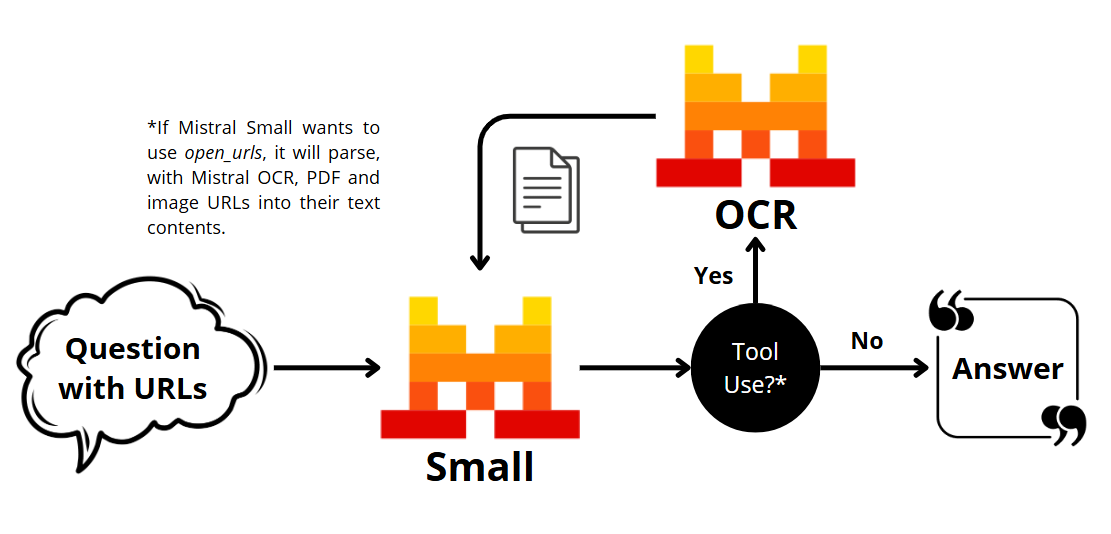

### Setup
First, let's install `mistralai`

In [ ]:
!pip install mistralai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.6/271.6 kB 14.4 MB/s eta 0:00:00


We can now set up our client. You can create an API key on our [Plateforme](https://console.mistral.ai/api-keys/).

In [ ]:
from mistralai import Mistral

api_key = "API_KEY"
client = Mistral(api_key=api_key)
text_model = "mistral-small-latest"
ocr_model = "mistral-ocr-latest"

### System and Tool
For the model to be aware of its purpose and what it can do, it's important to provide a clear system prompt with instructions and explanations of any tools it may have access to.

Let's define a system prompt and the tools it will have access to, in this case, `open_urls`.

*Note: `open_urls` can easily be customized with other resources and models ( for summarization, for example ) and many other features. In this demo, we are going for a simpler approach.*

In [ ]:
system = """You are an AI Assistant with document understanding via URLs. You will be provided with URLs, and you must answer any questions related to those documents.

# OPEN URLS INSTRUCTIONS
You can open URLs by using the `open_urls` tool. It will open webpages and apply OCR to them, retrieving the contents. Use those contents to answer the user.
Only URLs pointing to PDFs and images are supported; you may encounter an error if they are not; provide that information to the user if required."""

In [ ]:
def _perform_ocr(url: str) -> str:
    try:   # Apply OCR to the PDF URL
        response = client.ocr.process(
            model=ocr_model,
            document={
                "type": "document_url",
                "document_url": url
                }
            )
    except Exception:
        try:  # IF PDF OCR fails, try Image OCR
            response = client.ocr.process(
                model=ocr_model,
                document={
                    "type": "image_url",
                    "image_url": url
                    }
                )
        except Exception as e:
            return e  # Return the error to the model if it fails, otherwise return the contents
    return "\n\n".join([f"### Page {i+1}\n{response.pages[i].markdown}" for i in range(len(response.pages))])

In [ ]:
def open_urls(urls: list) -> str:
    contents = "# Documents"
    for url in urls:
        contents += f"\n\n## URL: {url}\n{_perform_ocr(url)}"
    return contents

We also have to define the Tool Schema that will be provided to our API and model.

By following the [documentation](https://docs.mistral.ai/capabilities/function_calling/), we can create something like this:

In [ ]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "open_urls",
            "description": "Open URLs websites (PDFs and Images) and perform OCR on them.",
            "parameters": {
                "type": "object",
                "properties": {
                    "urls": {
                        "type": "array",
                        "description": "The URLs list.",
                    }
                },
                "required": ["urls"],
            },
        },
    },
]

In [ ]:
names_to_functions = {
    'open_urls': open_urls
}

### Test
Everything is ready; we can quickly create a while loop to chat with our model directly in the console.

The model will use `open_urls` each time URLs are mentioned. If they are PDFs or photos, it will perform OCR and provide the raw text contents to the model, which will then use them to answer the user.

#### Example Prompts ( PDF & Image )
- Could you summarize what this research paper talks about? https://arxiv.org/pdf/2410.07073
- What is written here: https://jeroen.github.io/images/testocr.png

In [ ]:
import json

messages = [{"role": "system", "content": system}]
while True:
    # Insert user input, quit if desired
    user_input = input("User > ")
    if user_input == "quit":
        break
    messages.append({"role": "user", "content": user_input})

    # Loop Mistral Small tool use until no tool called
    while True:
        response = client.chat.complete(
            model = text_model,
            messages = messages,
            temperature = 0,
            tools = tools
        )
        messages.append({"role":"assistant", "content": response.choices[0].message.content, "tool_calls": response.choices[0].message.tool_calls})

        # If tool called, run tool and continue, else break loop and reply
        if response.choices[0].message.tool_calls:
            tool_call = response.choices[0].message.tool_calls[0]
            function_name = tool_call.function.name
            function_params = json.loads(tool_call.function.arguments)
            function_result = names_to_functions[function_name](**function_params)
            messages.append({"role":"tool", "name":function_name, "content":function_result, "tool_call_id":tool_call.id})
        else:
            break

    print("Assistant >", response.choices[0].message.content)

Assistant > The research paper titled "Pixtral 12B" introduces a 12-billion-parameter multimodal language model designed to understand both natural images and documents. The model is trained on a large-scale dataset of interleaved image and text documents, enabling it to perform multi-turn, multi-image conversations. Pixtral 12B is built on a transformer architecture and includes a new vision encoder, PixtralViT, which allows it to process images at their native resolution and aspect ratio. This flexibility is achieved through a novel RoPE-2D implementation, which supports variable image sizes and aspect ratios without the need for interpolation.

The model's performance is evaluated on various multimodal benchmarks, where it outperforms other open-source models of similar sizes, such as Qwen-2-VL 7B and Llama-3.2 11B. Pixtral 12B also matches or exceeds the performance of much larger models like Llama-3.2 90B and closed-source models like Claude-3 Haiku and Gemini-1.5 Flash 8B. The pa

## Built-In
Mistral provides a built-in feature that leverages OCR with all models. By providing a URL pointing to a document, you can extract text data that will be provided to the model.

Following, there is a simple, quick, example of how to make use of this feature by extracting PDF URLs with regex and uploading them as a `document_url`.

### System and Regex
Let's define a simple system prompt, since there is no tool call required for this demo we can be fairly straightforward.

In [ ]:
system = "You are an AI Assistant with document understanding via URLs. You may be provided with URLs, followed by their corresponding OCR."

To extract the URLs, we will use regex to extract any URL pattern from the user query.

*Note: We will assume there will only be PDF files for simplicity.*

In [ ]:
import re

def extract_urls(text: str) -> list:
    url_pattern = r'\b((?:https?|ftp)://(?:www\.)?[^\s/$.?#].[^\s]*)\b'
    urls = re.findall(url_pattern, text)
    return urls

### Test
We can now try it out, we setup so that for each query all urls are extracted and added to the query properly.

#### Example Prompts ( PDFs )
- Could you summarize what this research paper talks about? https://arxiv.org/pdf/2410.07073
- Explain this architecture: https://arxiv.org/abs/2401.04088

In [ ]:
import json

messages = [{"role": "system", "content": system}]
while True:
    user_input = input("User > ")
    if user_input.lower() == "quit":
        break

    # Extract URLs from the user input, assuming they are always PDFs
    document_urls = extract_urls(user_input)
    user_message_content = [{"type": "text", "text": user_input}]
    for url in document_urls:
        user_message_content.append({"type": "document_url", "document_url": url})
    messages.append({"role": "user", "content": user_message_content})

    # Send the messages to the model and get a response
    response = client.chat.complete(
        model=text_model,
        messages=messages,
        temperature=0
    )
    messages.append({"role": "assistant", "content": response.choices[0].message.content})

    print("Assistant >", response.choices[0].message.content)


User > hi
Assistant > Hello! How can I assist you today? If you have any documents or URLs you'd like me to help with, feel free to share them.
User > quit
